In this notebook we will be doing some further processing on the prefiltered data for the Victim From Predators disclosure (VFP) stage. It is important to note that only suspicious conversations (conversations that contain predator(s)) are fed into the VFP.

There are a few decisions to be made:
* We have to decide the type of document we feed into the VFP. A document contains messages written by a unique author ideantified by a id.
    - We could feed only one document per author. This means that we will be concantenating all messages from a unique author possible from multiple conversations if that author partook in multiple conversations in the dataset. The benefit of this approach is that we could possibly get a better picture of predators if we combine all messages in all conversations together.
    - We could feed one document per author per conversation. This means if an author partook in multiple conversations we will have multiple documents for that author. The benefit of this is this would better reflect the type of data in real-world.

We will use the second option for now.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET #for parsing the xml file
import csv #for working on csv files


def get_susp_conv_dict(data_path):#data path the path for the dataset
    labels_dict = {} #dictionary to store conversation id and label
    with open(data_path + 'sci_labels.csv', 'r') as f: # open the labels file in reading mode
        file = csv.reader(f) #Return a reader object file which will iterate over lines in the given csvfile.
        for row in file: #for each row(line) in file set the labels dictionary
            labels_dict[row[0]] = row[1] #unique conversation id and the label
    return labels_dict # return the dictionary labels library


def get_predators_dict(file): #file the path for the dataset (For getting predator dictionary)
    all_predators = {} #dictionary to store the list of predators
    with open(file, 'r') as f: # open the labels file in reading mode
        reader = csv.reader(f) #Return a reader object file which will iterate over lines in the given csvfile.
        for row in reader: #for each row(reader) in file set the labels dictionary
            all_predators[row[0]] = 1 
    return all_predators # return the all the predators library
            

def get_features_labels(root, labels_dict, all_predators): #root of tree and the labels dictionary 
#created are the parameters and the predatory list
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        # only get suspicious conversations
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {} # author convection dictionary
        for message in conversation: 
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(-1)
    return corpus, labels #return list of conversations and labels

In [ ]:
#setting the path for train data
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml') #parsing the xml file to tree
train_root = training_xml.getroot() #obtaining the root of the tree for training

#setting the path for test data 
test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml') #parsing the xml file to tree
test_root = test_xml.getroot() #obtaining the root of the tree

#calling get features and get labels function
pred_train_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path)) #gets a list of suspecious convection and predators in order for training
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path)) #gets a list of suspecious convection and predators in order for testing

TODO: Save the model once trained to a pickle file!!!

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  # module can be used to extract features 
# in a format supported by machine learning algorithms from datasets consisting of text.

import scipy # an open-source library used for solving mathematical, scientific, engineering,
# and technical problems

import numpy as np #  is a Python library used for working with arrays under the np alias

vectorizer = TfidfVectorizer(ngram_range=(1,2)) # ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
#This is an example for vector;   Unigram: This, is, an, example, for, vector;single words    Bigram: This is, an example, for vector; two words

# vectorizer = TfidfVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(train_corpus) # # Vectorize the training data

X_test = vectorizer.transform(test_corpus) # Vectorize the testing data

# Load data for train and test
print("Training data shape: {}".format(X_train.shape)) 
print("Testing data shape: {}".format(X_test.shape))

X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

print("Training data shape: {}".format(X_train.shape))
print("Testing data shape: {}".format(X_test.shape))
print("Training label shape: {}".format(y_train.shape))
print("Testing label shape: {}".format(y_test.shape))

Training data shape: (1846, 123268)
Testing data shape: (5608, 123268)
Training data shape: (1846, 123268)
Testing data shape: (5608, 123268)
Training label shape: (1846,)
Testing label shape: (5608,)


linear, tol=0.01, Accuracy: 0.9349930418223101
linear, tol=0.001, Accuracy: 0.9349930418223101
linear, tol=0.0001, Accuracy: 0.9349930418223101
linear, tol=1e-05, Accuracy: 0.9349930418223101


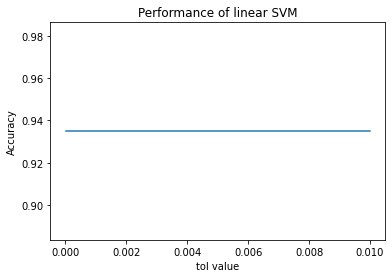

Best performing linear kernel SVM: C=0.01, Acc=0.9349930418223101


In [ ]:
from sklearn import svm # Importing SVM Libraries
from sklearn.model_selection import KFold  # Provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds
import matplotlib.pyplot as plt #  is a collection of functions in the popular visualization package
# Matplotlib. Its functions manipulate elements of a figure, such as creating a figure,
# creating a plotting area,etc
from sklearn import metrics # module implements functions assessing prediction error for specific purposes
import heapq # provides an implementation of the heap queue algorithm, also known as the priority queue
# algorithm
import operator
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.svm import LinearSVC

num_fold = 5
k_fold = KFold(num_fold, True, 1)
kernel = 'linear'
acc = []
if kernel == 'linear':
#     for coef_c in np.arange(1, 30, 10):
    for tol in [1e-2, 1e-3, 1e-4, 1e-5]:
        acc_arr = np.zeros(num_fold)
        ind = 0
        for train_rows, val_rows in k_fold.split(X_train):
#             model = svm.SVC(kernel=kernel, C=1, gamma=gamma_val, random_state=0)
            model = LinearSVC(random_state=0, tol=tol, loss='squared_hinge', dual=True)
            model.fit(X_train[train_rows], y_train[train_rows])
            pred_y = model.predict(X_train[val_rows])
            acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
            ind += 1
        acc.append([tol, np.mean(acc_arr)])
#         print("{}, c={}, Accuracy: {}".format(kernel, coef_c, acc[len(acc)-1][1]))
        print("{}, tol={}, Accuracy: {}".format(kernel, tol, acc[len(acc)-1][1]))
    plt.plot([i[0] for i in acc], [i[1] for i in acc])
    plt.title("Performance of {} SVM".format(kernel))
    plt.xlabel("tol value")
    plt.ylabel("Accuracy")
    # plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
    plt.show()
    best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
    print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))
#elif kernel == 'poly':
#    for degree in range(10):
#        for coef_c in [1,10,100]:
#            acc_arr = np.zeros(num_fold)
#            ind = 0
#            for train_rows, val_rows in k_fold.split(X_train):
#                model = svm.SVC(kernel=kernel, C=coef_c, gamma='auto', random_state=0, degree=degree)
#                model.fit(X_train[train_rows], y_train[train_rows])
#                pred_y = model.predict(X_train[val_rows])
#                acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
#                ind += 1
#            acc.append([degree, coef_c, np.mean(acc_arr)])
#           print("{}, c={}, deg={}, Accuracy: {}".format(kernel, coef_c, degree, acc[len(acc)-1][2]))
#    acc = np.array(acc)
#    # print(acc)
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#   surf = ax.scatter3D(acc[:, 0], acc[:, 1], acc[:, 2])
#    # fig.colorbar(surf, shrink=0.5, aspect=5)
#    plt.xlabel("Degree of polynomial SVM")
#    plt.ylabel("C coefficient value")
#    plt.title("Performance of Polynomial SVM")
#    # plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
#    plt.show()
#    best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
#    print("Best performing poly kernel SVM: degree={}, C={}, Acc={}".format(best[0], best[1], best[2]))

In [ ]:
# model = svm.SVC(kernel='linear', C=best[0], gamma='auto', random_state=0)
model = LinearSVC(random_state=0, tol=1e-5, loss='squared_hinge')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

0.8521754636233951


In [ ]:
import pickle
import datetime

# save the model to the models folder
filename = '/content/drive/MyDrive/online-grooming-detector-master/models/VFP_SVM_' + "{:.2f}_".format(metrics.accuracy_score(y_test, pred_y)) + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.sav'
pickle.dump(model, open(filename, 'wb'))